<a href="https://colab.research.google.com/github/cartmarsh/TwitterSentiment/blob/main/quora_sincere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks and Embeddings for Natural Language Processing

Outline:
- Download the Data
- Prepare Data for Training
- Logistic Regression Model
- Feed Forward Nueral Network


Dataset: https://www.kaggle.com/c/quora-insincere-questions-classification

## Download the Data

Upload your `kaggle.json` file to Colab

In [11]:
!pwd

/content


In [12]:
import os

In [13]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
IS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

In [ ]:
if IS_KAGGLE:
    data_dir = '../input/quora-insincere-questions-classification'
    train_fname = data_dir + '/train.csv'
    test_fname = data_dir + '/test.csv'
    sample_fname = data_dir + '/sample_submission.csv'
else:
    os.environ['KAGGLE_CONFIG_DIR'] = '.'
    !kaggle competitions download -c quora-insincere-questions-classification -f train.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f test.csv -p data
    !kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv -p data
    train_fname = 'data/train.csv.zip'
    test_fname = 'data/test.csv.zip'
    sample_fname = 'data/sample_submission.csv.zip' 

In [14]:
!kaggle competitions download -c quora-insincere-questions-classification

100% 6.03G/6.03G [00:57<00:00, 157MB/s]
100% 6.03G/6.03G [00:57<00:00, 113MB/s]


In [15]:
!ls


kaggle.json  quora-insincere-questions-classification.zip  sample_data


In [16]:
!unzip quora-insincere-questions-classification.zip

Archive:  quora-insincere-questions-classification.zip
  inflating: embeddings.zip          
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [17]:
import pandas as pd


In [18]:
!ls


embeddings.zip				      sample_data	     train.csv
kaggle.json				      sample_submission.csv
quora-insincere-questions-classification.zip  test.csv


In [19]:
raw_df = pd.read_csv("train.csv")
raw_test = pd.read_csv("test.csv")
raw_sub = pd.read_csv("sample_submission.csv")

In [20]:
raw_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Prepare Data for Training


Outline:
- Convert text to TF-IDF Vectors
- Split training & validation set
- Convert to PyTorch tensors

- Create PyTorch DataLoaders

### Conversion to TF-IDF Vectors

In [21]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords


In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
word_tokenize("do you even, lift() 7")

['do', 'you', 'even', ',', 'lift', '(', ')', '7']

In [25]:
stemmer = SnowballStemmer(language='english')

In [26]:
def tokenize(text):
  return [stemmer.stem(token) for token in word_tokenize(text)]

In [27]:
tokenize("is this token,ize wo wokring or whaaa")

['is', 'this', 'token', ',', 'ize', 'wo', 'wokr', 'or', 'whaaa']

In [28]:
english_stopwords = stopwords.words('english')

In [29]:
", ".join(english_stopwords)

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [30]:
## we give vectorizer all the created parameters
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words=english_stopwords, max_features=1000)

In [31]:
sample_df = raw_df.sample(100_000)

In [32]:
vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7fc0c5b41200>)

In [33]:
vectorizer.get_feature_names_out()[1000:2000]

array([], dtype=object)

In [96]:
inputs_sub = vectorizer.transform(raw_test.question_text)

In [ ]:
inputs.shape

In [39]:
inputs = vectorizer.transform(sample_df.question_text)
targets = sample_df.target 

In [40]:
inputs.shape

(100000, 1000)

In [41]:
type(inputs)


scipy.sparse.csr.csr_matrix

### Split training and validation set

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
inputs.shape

(100000, 1000)

In [44]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, sample_df.target, test_size=0.3)

In [45]:
train_inputs.shape


(70000, 1000)

In [46]:
train_targets.shape

(70000,)

### Convert to PyTorch Tensors

In [47]:
import torch

In [48]:
train_input_tensors = torch.tensor(train_inputs.toarray()).float()

In [49]:
val_input_tensors = torch.tensor(val_inputs.toarray()).float()

In [50]:
train_input_tensors

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3765, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [51]:
train_target_tensors = torch.tensor(train_targets.values)
val_target_tensors = torch.tensor(val_targets.values)

In [100]:
test_input_tensors = torch.tensor(inputs_sub.toarray()).float()

In [101]:
test_input_tensors.shape

torch.Size([375806, 1000])

## Create PyTorch Data Loaders

In [102]:
from torch.utils.data import TensorDataset, DataLoader

In [103]:
train_ds = TensorDataset(train_input_tensors, train_target_tensors)
val_ds = TensorDataset(val_input_tensors, val_target_tensors)
test_ds = TensorDataset(test_input_tensors)

In [104]:
BATCH_SIZE=128

In [105]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [106]:
for batch in train_dl:
  batch_inputs = batch[0]
  batch_targets = batch[1]
  print(batch_inputs.shape)
  print(batch_targets.shape)
  break

torch.Size([128, 1000])
torch.Size([128])


In [107]:
import torch.nn as nn
import torch.nn.functional as F

In [108]:
class QuoraNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1000, 512)
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256, 128)
    self.layer4 = nn.Linear(128, 1)
    
  
  def forward(self, inputs):
    out = self.layer1(inputs)
    out = F.relu(out)
    out = self.layer2(out)
    out = F.relu(out)
    out = self.layer3(out)
    out = F.relu(out)
    out = self.layer4(out)
    return out




In [109]:
model = QuoraNet()

In [110]:
from sklearn.metrics import accuracy_score, f1_score

In [111]:
for batch in train_dl:
  bi, bt = batch
  print("inputs.shape", bi.shape)

  bo = model(bi)
  print("bo.shape", bo.shape)


  # convert outputs to props

  probs = torch.sigmoid(bo[:,0])
  print(probs[:10])

  # Convert probs to predictions

  preds = (probs > 0.5).int()
  print(preds[:10])

  # check metrics

  print("accuracy: ", accuracy_score(bt, preds))
  print("f1 score: ", f1_score(bt, preds))

  # Loss

  print("loss: ", F.binary_cross_entropy(preds.float(), bt.float()))

  break

inputs.shape torch.Size([128, 1000])
bo.shape torch.Size([128, 1])
tensor([0.4876, 0.4875, 0.4875, 0.4875, 0.4879, 0.4878, 0.4880, 0.4880, 0.4879,
        0.4879], grad_fn=<SliceBackward0>)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
accuracy:  0.9453125
f1 score:  0.0
loss:  tensor(5.4688)


In [112]:
def evaluate(model, dl):

  losses, accs, f1s = [], [], []

  # Loop over batches
  for batch in dl:
    inputs, targets = batch

    outputs = model(inputs)

    probs = torch.sigmoid(outputs[:,0])

    loss = F.binary_cross_entropy(probs.float(), targets.float(), weight=torch.tensor(20))

    preds = (probs > 0.5).int()

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)

    losses.append(loss.item())
    accs.append(acc)
    f1s.append(f1)

  return torch.mean(torch.tensor(losses)).item(), torch.mean(torch.tensor(accs)).item(), torch.mean(torch.tensor(f1s)).item()



In [113]:
evaluate(model, train_dl)

(13.44267463684082, 0.9374143053016454, 0.0)

In [114]:
evaluate(model, val_dl)

(13.439901351928711, 0.9403147163120568, 0.0)

In [115]:
# Train the model
def fit(epochs, lr, model, train_dl, val_dl):
  history = []
  opt = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-05)


  for epoch in range(epochs):
    for batch in train_dl:
      inputs, targets = batch

      outputs = model(inputs)

      probs = torch.sigmoid(outputs[:,0])

      loss = F.binary_cross_entropy(probs.float(), targets.float(), weight=torch.tensor(20))


      #Perform optimization

      loss.backward()
      opt.step()
      # zero_grad delete the gradients that were calculated
      opt.zero_grad()

    loss, acc, f1 = evaluate(model, val_dl)
    print("Epoch {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 Score: {:.4f}".format(epoch+1, loss, acc, f1))
    history.append([loss, acc, f1])
  return history

In [116]:
history = []

In [117]:
history.append(evaluate(model, val_dl))

In [118]:
history += fit(5, 0.001, model,train_dl=train_dl, val_dl=val_dl)

Epoch 1; Loss: 3.0706; Accuracy: 0.9447; F1 Score: 0.4062
Epoch 2; Loss: 2.9904; Accuracy: 0.9476; F1 Score: 0.3682
Epoch 3; Loss: 3.0759; Accuracy: 0.9455; F1 Score: 0.4205
Epoch 4; Loss: 3.7507; Accuracy: 0.9428; F1 Score: 0.3780
Epoch 5; Loss: 5.3284; Accuracy: 0.9430; F1 Score: 0.3403


In [119]:
losses = [item[0] for item in history]
accs = [item[1] for item in history]
f1s = [item[2] for item in history]

In [120]:
import matplotlib.pyplot as plt

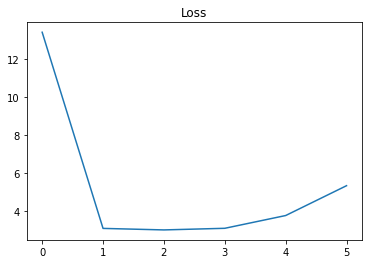

In [121]:
plt.title('Loss')
plt.plot(losses)

## Feed Forward Neural Network

## Make Predictions and Submit

In [122]:
small_df = raw_df.sample(20)

In [123]:
small_df

,qid,question_text,target
423486,5302bbfb39d41c69e6d3,How can I develop my intuition to help me in m...,0
150437,1d6b099714485e86b5a1,How can attorneys give you online advice and t...,0
589186,736a8543ff7481d498f8,Is dropping an year for CAT preparation a good...,0
75508,0ec70b9b4aecaf91101d,Where can I find the prettiest convertible wed...,0
1224954,f011a9cfa7797a60bf52,If the North Koreans caused an electric pulse ...,0
1092540,d61ba9ef49fa790c1387,What's the biggest mountain in Papua New Guinea?,0
374173,495ac1ff896c7fbe5c04,Coming in to some towns there are signs toutin...,0
222521,2b873e7ac5683628b6db,What is the Pentax equivalent of Canon 70D?,0
991222,c2366c5b245d63b375ea,As a half breed have you felt racisim against ...,0
1103581,d8494b9d5e543687369d,Is it okay to hold HCC shares?,0


In [124]:
def predict_df(df):
  inputs = vectorizer.transform(df.question_text)
  input_tensors = torch.tensor(inputs.toarray()).float()
  outputs = model(input_tensors)
  probs = torch.sigmoid(outputs[:,0])
  preds = (probs > 0.5).int()
  return preds


In [125]:
predict_df(small_df)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)

In [126]:
small_df.target.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [127]:
small_df[10:20].question_text

776633     White Liberals Love Farrakhan, Who Calls For A...
618731     What is the best cryptocurrency to invest for ...
77384         What have astronauts reported seeing in space?
671004              Should I quit/stop gaming as a teenager?
1186351    Is it okay to accept team role position withou...
652852                   How do Bacillus subtilis reproduce?
626006     Where can I find the secure folder on my Samsu...
963240     How can I stop being nervous when the professo...
1241784    What should I do when someone's good influence...
602450     How can a Greek man and an African American ma...
Name: question_text, dtype: object

In [128]:
def predict_text(text):
  df = pd.DataFrame({'question_text': [text]})
  inputs = vectorizer.transform(df.question_text)
  input_tensors = torch.tensor(inputs.toarray()).float()
  outputs = model(input_tensors)
  probs = torch.sigmoid(outputs[:,0])
  preds = (probs > 0.5).int()
  return preds

In [129]:
predict_text("How small can we construct nanoprozessors?")

tensor([0], dtype=torch.int32)

In [130]:
predict_text("Why is Trump so stupid?")

tensor([0], dtype=torch.int32)

## Generate Predictions for Test Set

In [131]:
import numpy as np

In [132]:
def make_preds(dl):
  all_preds = []
  for batch in dl:
    inputs = batch[0]
    outputs = model(inputs)
    probs = torch.sigmoid(outputs[:,0])
    preds = (probs > 0.5).int()
    all_preds.append(preds.detach().numpy()) 
  np.concatenate(all_preds)

  return preds

In [133]:
test_preds = make_preds(test_dl)

In [134]:
test_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [135]:
len(test_preds)

126

In [136]:
raw_sub

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [137]:
raw_test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [138]:
test_preds = make_preds(test_dl)

In [139]:
len(test_preds)

126

In [140]:
raw_sub

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
...,...,...
375801,ffff7fa746bd6d6197a9,0
375802,ffffa1be31c43046ab6b,0
375803,ffffae173b6ca6bfa563,0
375804,ffffb1f7f1a008620287,0


In [141]:
test_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [142]:
raw_sub.prediction = test_preds

ValueError: ignored

In [ ]:
sub_df.to_csv('submission_sincere_quora.csv', index=None)